In [1]:
import numpy as np
import matplotlib.pyplot as plt


# Configuration

In [2]:
slot = 1000
slot_duration = 8

surgery_request = ['A', 'B', 'C']
hospital = ['a', 'b', 'c']

surgery_request_pref = {
  'A': ['a', 'b', 'c'],
  'A2': ['a', 'b', 'c'],
  'A3': ['a', 'b', 'c'],
  'B': ['b', 'a', 'c'],
  'B2': ['b', 'a', 'c'],
  'B3': ['b', 'a', 'c'],
  'C': ['a', 'c', 'b'],
  'C2': ['a', 'c', 'b'],
  'C3': ['a', 'c', 'b']}

hospital_pref = {
  'a': ['B', 'B2', 'B3', 'C', 'C2', 'C3', 'A', 'A2', 'A3'],
  'b': ['A', 'A2', 'A3', 'B', 'B2', 'B3', 'C', 'C2', 'C3'],
  'c': ['C', 'C2', 'C3', 'A', 'A2', 'A3', 'B', 'B2', 'B3']}

t_A_a =  2; t_B_a =  6; t_C_a =  4;
t_A_b = 10; t_B_b =  5; t_C_b = 15;
t_A_c = 30; t_B_c = 20; t_C_c = 10;

u_A_a = 2; u_B_a = 7; u_C_a = 5;
u_A_b = 7; u_B_b = 5; u_C_b = 2;
u_A_c = 5; u_B_c = 2; u_C_c = 7;

In [3]:
eval('t_A_a')

2

# Generate requests

Text(0.5, 1.0, 'C requests')

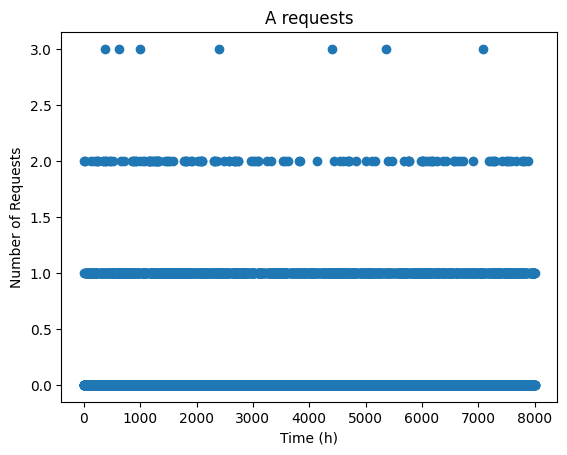

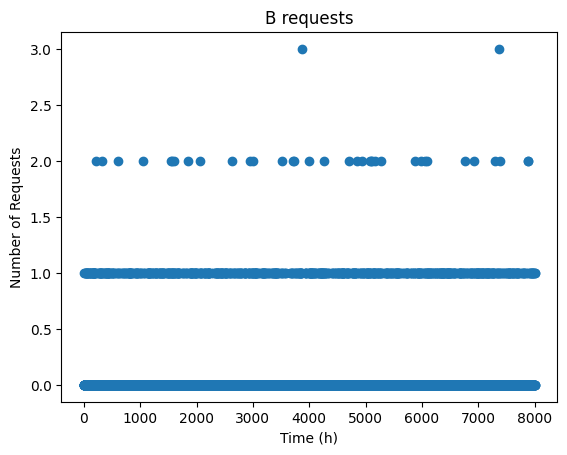

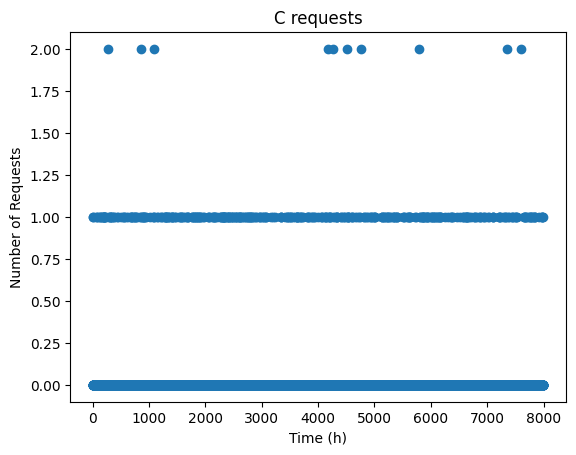

In [4]:
np.random.seed(0)
request_A = np.random.poisson(lam = 0.20, size = slot * slot_duration)
request_B = np.random.poisson(lam = 0.10, size = slot * slot_duration)
request_C = np.random.poisson(lam = 0.05, size = slot * slot_duration)

plt.figure()
plt.scatter(range(slot * slot_duration), request_A)
plt.xlabel('Time (h)')
plt.ylabel('Number of Requests')
plt.title('A requests')

plt.figure()
plt.scatter(range(slot * slot_duration), request_B)
plt.xlabel('Time (h)')
plt.ylabel('Number of Requests')
plt.title('B requests')

plt.figure()
plt.scatter(range(slot * slot_duration), request_C)
plt.xlabel('Time (h)')
plt.ylabel('Number of Requests')
plt.title('C requests')

In [5]:
request_slot = []
for i in range(slot):
  x = []
  for j in range(slot_duration):
    x.append('A' * request_A[(i-1)*slot_duration + j])
    x.append('B' * request_B[(i-1)*slot_duration + j])
    x.append('C' * request_C[(i-1)*slot_duration + j])
  x = [i for i in x if i != '']
  x = ''.join(x)
  request_slot.append(x)

# A:

# The DA Algorithm

In [6]:
def DA(Men_Free, Women_Free):

    # Initialization
    Men = surgery_request
    Women = hospital

    # Preferences
    Men_Pref = surgery_request_pref

    Women_Pref = hospital_pref

    Matches = {Men_Free[0]:  '', Men_Free[1]: '', Men_Free[2]: ''}

    # the algorithm
    patient = len(Men)
    while (len(Men_Free) > len(Men) - len(Women_Free)) or (patient > 0 and len(Men_Free)>0):
        br = False
        for man in Men_Free:
            for woman in Men_Pref[man]:
                if woman not in Women_Free:
                    continue
                if woman not in list(Matches.values()):
                    Matches[man] = woman
                    Men_Free.remove(man)
                    br = True
                    break
                elif woman in list(Matches.values()):
                    current_suitor = list(Matches.keys())[list(Matches.values()).index(woman)]
                    w_list = Women_Pref.get(woman)
                    if w_list.index(man) < w_list.index(current_suitor):
                        Matches[man] = woman
                        Men_Free.remove(man)
                        Matches[current_suitor] = ''
                        Men_Free.append(current_suitor)
                        br = True
                        break
                    else:
                        patient -= 1
            if br:
                break
    return Matches



def convert(Men_Free):
    Men_Free_converted = []

    count_dict = {}

    for element in Men_Free:
        if element in count_dict:
            count_dict[element] += 1
            Men_Free_converted.append(element + str(count_dict[element]))
        else:
            count_dict[element] = 1
            Men_Free_converted.append(element)

    return Men_Free_converted



def update_queue(queue, Matches):
    nonempty_keys = [key for key, value in Matches.items() if value != '']
    for x in nonempty_keys:
        queue = queue.replace(x[0], '', 1)
    return queue



def hospital_free(busy_slots, Matches):
    women_free = []
    keys = [(key, value) for key, value in Matches.items() if value != '']

    for x, y in keys:
        X = 't_' + x[0] +'_'+ y
        if y == 'a':
            busy_slots[0] = eval(X) // slot_duration
        elif y == 'b':
            busy_slots[1] = eval(X) // slot_duration
        elif y== 'c':
            busy_slots[2] = eval(X) // slot_duration

    if busy_slots[0] == 0:
            women_free.append('a')
    if busy_slots[1] == 0:
            women_free.append('b')
    if busy_slots[2] == 0:
            women_free.append('c')

    busy_slots -= 1
    busy_slots = np.array([max(0, num) for num in busy_slots])

    return women_free, busy_slots


def Mean(Matches, M1, M2, M3, n):
    keys = [(key, value) for key, value in Matches.items() if value != '']

    for x, y in keys:
        X = 't_' + x[0] +'_'+ y
        Y = 'u_' + x[0] +'_'+ y

        if x[0] == 'A':
            M1[0] += eval(X)
            if k=='0':
                M2[0] += eval(X) + (eval(X) // slot_duration) * slot_duration
            else:
                M2[0] += eval(X)
            M3[0] += eval(Y)
            n[0] += 1
        elif x[0] == 'B':
            M1[1] += eval(X)
            if k=='0':
                M2[1] += eval(X) + (eval(X) // slot_duration) * slot_duration
            else:
                M2[1] += eval(X)
            M3[1] += eval(Y)
            n[1] += 1
        elif x[0] == 'C':
            M1[2] += eval(X)
            if k=='0':
                M2[2] += eval(X) + (eval(X) // slot_duration) * slot_duration
            else:
                M2[2] += eval(X)
            M3[2] += eval(Y)
            n[2] += 1

    return M1, M2, M3, n

In [7]:
k = '0'
Women_Free = list(['a', 'b', 'c'])
busy_slots = np.array([0, 0, 0])
M1 = np.zeros([1+slot, 3]); M2 = np.zeros([1+slot, 3]); n = np.ones([1+slot, 3]);
M3 = np.zeros([1+slot, 3]); mean1 = np.zeros([slot, 3]); mean2 = np.zeros([slot, 3]);
mean3 = np.zeros([slot, 3]);

queue = ''
total_req = ''
Matches = [None] * slot
for t in range(slot):
    queue = queue + request_slot[t]
    total_req = total_req + request_slot[t]
    if len(queue) >= 3:
        Men_Free = list(queue[:3])
        Men_Free = convert(Men_Free)
        Matches[t] = (DA(Men_Free, Women_Free))
        queue = update_queue(queue, Matches[t])
        Women_Free, busy_slots = hospital_free(busy_slots, Matches[t])
        M1[t+1], M2[t+1], M3[t+1], n[t+1] = Mean(Matches[t], M1[t], M2[t], M3[t], n[t])
        mean1[t] = sum(M1[:t+1]) / sum(n[:t+1])
        mean2[t] = sum(M2[:t+1]) / sum(n[:t+1])
        mean3[t] = sum(M3[:t+1]) / sum(n[:t+1])
    else:
        mean1[t] = mean1[t-1]
        mean2[t] = mean2[t-1]
        mean3[t] = mean3[t-1]

print(f'The number of remaining requests out of the total of {len(total_req)} \
is {len(queue)}.')

The number of remaining requests out of the total of 2774 is 994.


Text(0.5, 1.0, 'C surgery')

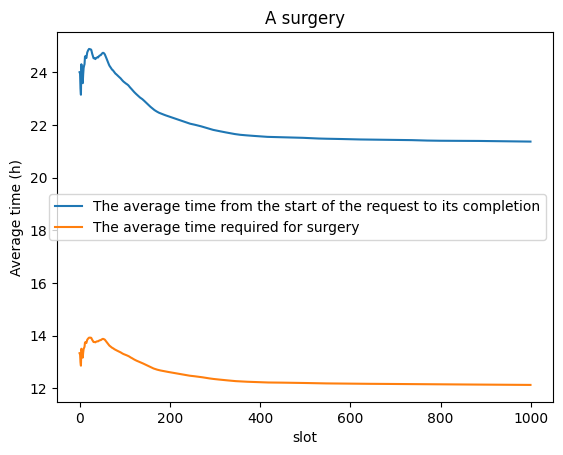

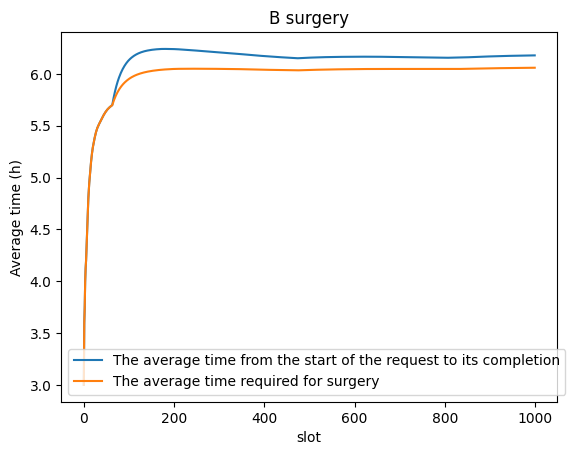

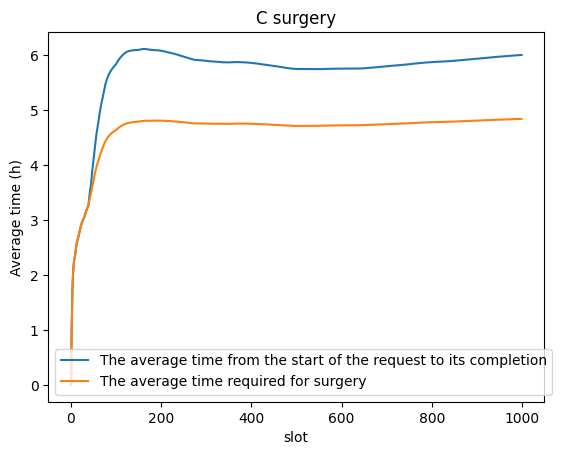

In [8]:
plt.figure()
plt.plot(range(slot), mean2[:,0])
plt.plot(range(slot), mean1[:,0])
plt.xlabel('slot')
plt.ylabel('Average time (h)')
plt.legend(['The average time from the start of the request to its completion', \
            'The average time required for surgery'])
plt.title('A surgery')

plt.figure()
plt.plot(range(slot), mean2[:,1])
plt.plot(range(slot), mean1[:,1])
plt.xlabel('slot')
plt.ylabel('Average time (h)')
plt.legend(['The average time from the start of the request to its completion', \
            'The average time required for surgery'])
plt.title('B surgery')

plt.figure()
plt.plot(range(slot), mean2[:,2])
plt.plot(range(slot), mean1[:,2])
plt.xlabel('slot')
plt.ylabel('Average time (h)')
plt.legend(['The average time from the start of the request to its completion', \
            'The average time required for surgery'])
plt.title('C surgery')

Text(0.5, 1.0, 'C surgery')

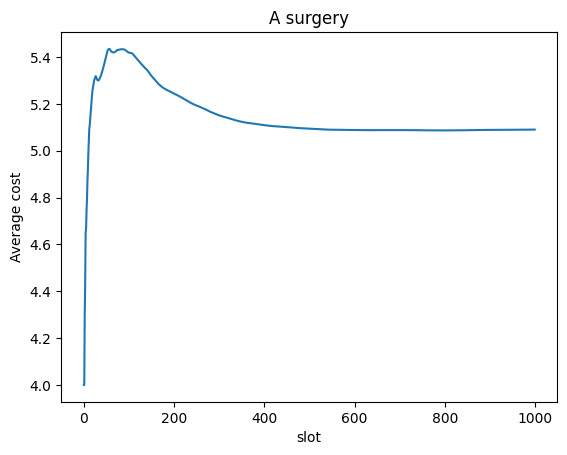

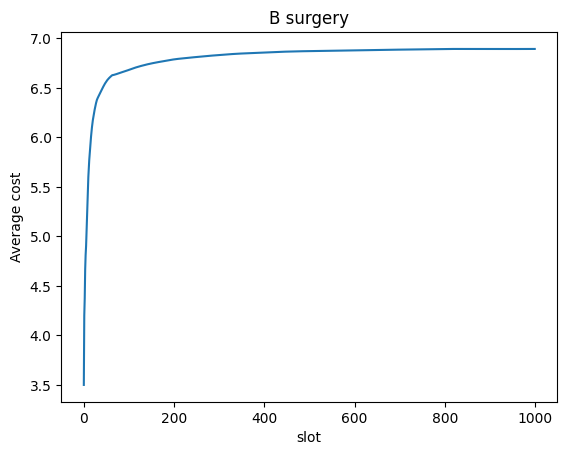

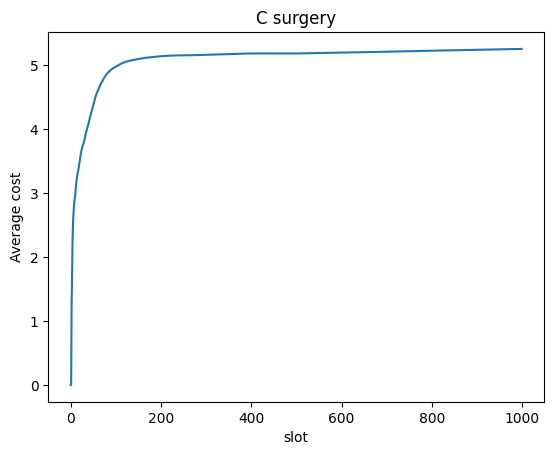

In [9]:
plt.figure()
plt.plot(range(slot), mean3[:,0])
plt.xlabel('slot')
plt.ylabel('Average cost')
plt.title('A surgery')

plt.figure()
plt.plot(range(slot), mean3[:,1])
plt.xlabel('slot')
plt.ylabel('Average cost')
plt.title('B surgery')

plt.figure()
plt.plot(range(slot), mean3[:,2])
plt.xlabel('slot')
plt.ylabel('Average cost')
plt.title('C surgery')

In [10]:
np.random.seed(0)
landa = 0.9
request_A = np.random.poisson(lam = 0.20 * landa, size = slot * slot_duration)
request_B = np.random.poisson(lam = 0.10 * landa, size = slot * slot_duration)
request_C = np.random.poisson(lam = 0.05 * landa, size = slot * slot_duration)

request_slot = []
for i in range(slot):
  x = []
  for j in range(slot_duration):
    x.append('A' * request_A[(i-1)*slot_duration + j])
    x.append('B' * request_B[(i-1)*slot_duration + j])
    x.append('C' * request_C[(i-1)*slot_duration + j])
  x = [i for i in x if i != '']
  x = ''.join(x)
  request_slot.append(x)

Women_Free = list(['a', 'b', 'c'])
busy_slots = np.array([0, 0, 0])
M1 = np.zeros([1+slot, 3]); M2 = np.zeros([1+slot, 3]); n = np.ones([1+slot, 3]);
M3 = np.zeros([1+slot, 3]); mean1 = np.zeros([slot, 3]); mean2 = np.zeros([slot, 3]);
mean3 = np.zeros([slot, 3]);

queue = ''
total_req = ''
Matches = [None] * slot
for t in range(slot):
    queue = queue + request_slot[t]
    total_req = total_req + request_slot[t]
    if len(queue) >= 3:
        Men_Free = list(queue[:3])
        Men_Free = convert(Men_Free)
        Matches[t] = (DA(Men_Free, Women_Free))
        queue = update_queue(queue, Matches[t])
        Women_Free, busy_slots = hospital_free(busy_slots, Matches[t])
        M1[t+1], M2[t+1], M3[t+1], n[t+1] = Mean(Matches[t], M1[t], M2[t], M3[t], n[t])
        mean1[t] = sum(M1[:t+1]) / sum(n[:t+1])
        mean2[t] = sum(M2[:t+1]) / sum(n[:t+1])
        mean3[t] = sum(M3[:t+1]) / sum(n[:t+1])
    else:
        mean1[t] = mean1[t-1]
        mean2[t] = mean2[t-1]
        mean3[t] = mean3[t-1]

print(f'The number of remaining requests out of the total of {len(total_req)} \
is {len(queue)}.')

The number of remaining requests out of the total of 2502 is 725.


In [11]:
np.random.seed(0)
landa = 0.9 ** 2
request_A = np.random.poisson(lam = 0.20 * landa, size = slot * slot_duration)
request_B = np.random.poisson(lam = 0.10 * landa, size = slot * slot_duration)
request_C = np.random.poisson(lam = 0.05 * landa, size = slot * slot_duration)

request_slot = []
for i in range(slot):
  x = []
  for j in range(slot_duration):
    x.append('A' * request_A[(i-1)*slot_duration + j])
    x.append('B' * request_B[(i-1)*slot_duration + j])
    x.append('C' * request_C[(i-1)*slot_duration + j])
  x = [i for i in x if i != '']
  x = ''.join(x)
  request_slot.append(x)

Women_Free = list(['a', 'b', 'c'])
busy_slots = np.array([0, 0, 0])
M1 = np.zeros([1+slot, 3]); M2 = np.zeros([1+slot, 3]); n = np.ones([1+slot, 3]);
M3 = np.zeros([1+slot, 3]); mean1 = np.zeros([slot, 3]); mean2 = np.zeros([slot, 3]);
mean3 = np.zeros([slot, 3]);

queue = ''
total_req = ''
Matches = [None] * slot
for t in range(slot):
    queue = queue + request_slot[t]
    total_req = total_req + request_slot[t]
    if len(queue) >= 3:
        Men_Free = list(queue[:3])
        Men_Free = convert(Men_Free)
        Matches[t] = (DA(Men_Free, Women_Free))
        queue = update_queue(queue, Matches[t])
        Women_Free, busy_slots = hospital_free(busy_slots, Matches[t])
        M1[t+1], M2[t+1], M3[t+1], n[t+1] = Mean(Matches[t], M1[t], M2[t], M3[t], n[t])
        mean1[t] = sum(M1[:t+1]) / sum(n[:t+1])
        mean2[t] = sum(M2[:t+1]) / sum(n[:t+1])
        mean3[t] = sum(M3[:t+1]) / sum(n[:t+1])
    else:
        mean1[t] = mean1[t-1]
        mean2[t] = mean2[t-1]
        mean3[t] = mean3[t-1]

print(f'The number of remaining requests out of the total of {len(total_req)} \
is {len(queue)}.')

The number of remaining requests out of the total of 2250 is 473.


In [12]:
np.random.seed(0)
landa = 0.9 ** 3
request_A = np.random.poisson(lam = 0.20 * landa, size = slot * slot_duration)
request_B = np.random.poisson(lam = 0.10 * landa, size = slot * slot_duration)
request_C = np.random.poisson(lam = 0.05 * landa, size = slot * slot_duration)

request_slot = []
for i in range(slot):
  x = []
  for j in range(slot_duration):
    x.append('A' * request_A[(i-1)*slot_duration + j])
    x.append('B' * request_B[(i-1)*slot_duration + j])
    x.append('C' * request_C[(i-1)*slot_duration + j])
  x = [i for i in x if i != '']
  x = ''.join(x)
  request_slot.append(x)

Women_Free = list(['a', 'b', 'c'])
busy_slots = np.array([0, 0, 0])
M1 = np.zeros([1+slot, 3]); M2 = np.zeros([1+slot, 3]); n = np.ones([1+slot, 3]);
M3 = np.zeros([1+slot, 3]); mean1 = np.zeros([slot, 3]); mean2 = np.zeros([slot, 3]);
mean3 = np.zeros([slot, 3]);

queue = ''
total_req = ''
Matches = [None] * slot
for t in range(slot):
    queue = queue + request_slot[t]
    total_req = total_req + request_slot[t]
    if len(queue) >= 3:
        Men_Free = list(queue[:3])
        Men_Free = convert(Men_Free)
        Matches[t] = (DA(Men_Free, Women_Free))
        queue = update_queue(queue, Matches[t])
        Women_Free, busy_slots = hospital_free(busy_slots, Matches[t])
        M1[t+1], M2[t+1], M3[t+1], n[t+1] = Mean(Matches[t], M1[t], M2[t], M3[t], n[t])
        mean1[t] = sum(M1[:t+1]) / sum(n[:t+1])
        mean2[t] = sum(M2[:t+1]) / sum(n[:t+1])
        mean3[t] = sum(M3[:t+1]) / sum(n[:t+1])
    else:
        mean1[t] = mean1[t-1]
        mean2[t] = mean2[t-1]
        mean3[t] = mean3[t-1]

print(f'The number of remaining requests out of the total of {len(total_req)} \
is {len(queue)}.')

The number of remaining requests out of the total of 2004 is 229.


In [13]:
np.random.seed(0)
landa = 0.9 ** 4
request_A = np.random.poisson(lam = 0.20 * landa, size = slot * slot_duration)
request_B = np.random.poisson(lam = 0.10 * landa, size = slot * slot_duration)
request_C = np.random.poisson(lam = 0.05 * landa, size = slot * slot_duration)

request_slot = []
for i in range(slot):
  x = []
  for j in range(slot_duration):
    x.append('A' * request_A[(i-1)*slot_duration + j])
    x.append('B' * request_B[(i-1)*slot_duration + j])
    x.append('C' * request_C[(i-1)*slot_duration + j])
  x = [i for i in x if i != '']
  x = ''.join(x)
  request_slot.append(x)

Women_Free = list(['a', 'b', 'c'])
busy_slots = np.array([0, 0, 0])
M1 = np.zeros([1+slot, 3]); M2 = np.zeros([1+slot, 3]); n = np.ones([1+slot, 3]);
M3 = np.zeros([1+slot, 3]); mean1 = np.zeros([slot, 3]); mean2 = np.zeros([slot, 3]);
mean3 = np.zeros([slot, 3]);

queue = ''
total_req = ''
Matches = [None] * slot
for t in range(slot):
    queue = queue + request_slot[t]
    total_req = total_req + request_slot[t]
    if len(queue) >= 3:
        Men_Free = list(queue[:3])
        Men_Free = convert(Men_Free)
        Matches[t] = (DA(Men_Free, Women_Free))
        queue = update_queue(queue, Matches[t])
        Women_Free, busy_slots = hospital_free(busy_slots, Matches[t])
        M1[t+1], M2[t+1], M3[t+1], n[t+1] = Mean(Matches[t], M1[t], M2[t], M3[t], n[t])
        mean1[t] = sum(M1[:t+1]) / sum(n[:t+1])
        mean2[t] = sum(M2[:t+1]) / sum(n[:t+1])
        mean3[t] = sum(M3[:t+1]) / sum(n[:t+1])
    else:
        mean1[t] = mean1[t-1]
        mean2[t] = mean2[t-1]
        mean3[t] = mean3[t-1]

print(f'The number of remaining requests out of the total of {len(total_req)} \
is {len(queue)}.')

The number of remaining requests out of the total of 1818 is 46.


In [14]:
np.random.seed(0)
landa = 0.9 ** 4.3
request_A = np.random.poisson(lam = 0.20 * landa, size = slot * slot_duration)
request_B = np.random.poisson(lam = 0.10 * landa, size = slot * slot_duration)
request_C = np.random.poisson(lam = 0.05 * landa, size = slot * slot_duration)

request_slot = []
for i in range(slot):
  x = []
  for j in range(slot_duration):
    x.append('A' * request_A[(i-1)*slot_duration + j])
    x.append('B' * request_B[(i-1)*slot_duration + j])
    x.append('C' * request_C[(i-1)*slot_duration + j])
  x = [i for i in x if i != '']
  x = ''.join(x)
  request_slot.append(x)

Women_Free = list(['a', 'b', 'c'])
busy_slots = np.array([0, 0, 0])
M1 = np.zeros([1+slot, 3]); M2 = np.zeros([1+slot, 3]); n = np.ones([1+slot, 3]);
M3 = np.zeros([1+slot, 3]); mean1 = np.zeros([slot, 3]); mean2 = np.zeros([slot, 3]);
mean3 = np.zeros([slot, 3]);

queue = ''
total_req = ''
Matches = [None] * slot
for t in range(slot):
    queue = queue + request_slot[t]
    total_req = total_req + request_slot[t]
    if len(queue) >= 3:
        Men_Free = list(queue[:3])
        Men_Free = convert(Men_Free)
        Matches[t] = (DA(Men_Free, Women_Free))
        queue = update_queue(queue, Matches[t])
        Women_Free, busy_slots = hospital_free(busy_slots, Matches[t])
        M1[t+1], M2[t+1], M3[t+1], n[t+1] = Mean(Matches[t], M1[t], M2[t], M3[t], n[t])
        mean1[t] = sum(M1[:t+1]) / sum(n[:t+1])
        mean2[t] = sum(M2[:t+1]) / sum(n[:t+1])
        mean3[t] = sum(M3[:t+1]) / sum(n[:t+1])
    else:
        mean1[t] = mean1[t-1]
        mean2[t] = mean2[t-1]
        mean3[t] = mean3[t-1]

print(f'The number of remaining requests out of the total of {len(total_req)} \
is {len(queue)}.')

The number of remaining requests out of the total of 1766 is 5.


Text(0.5, 1.0, 'C surgery')

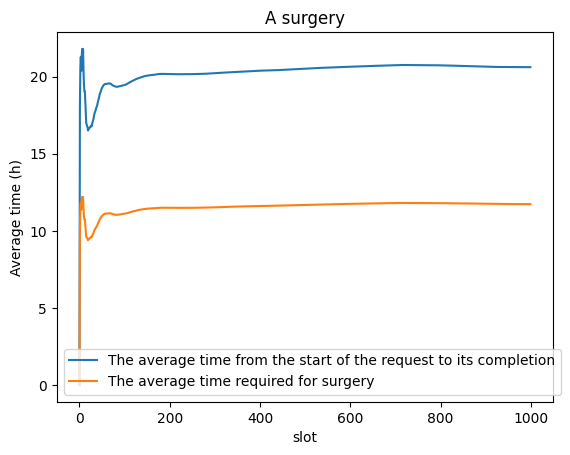

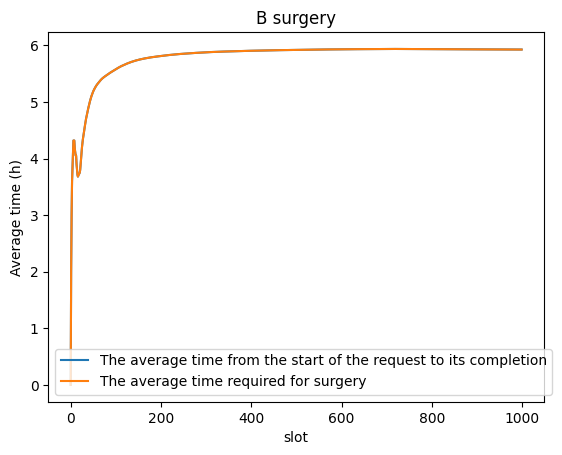

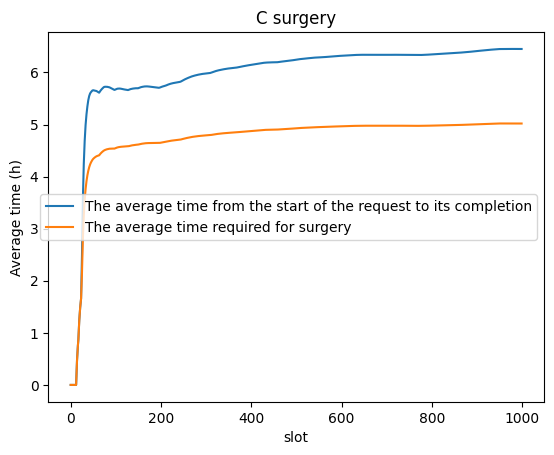

In [15]:
plt.figure()
plt.plot(range(slot), mean2[:,0])
plt.plot(range(slot), mean1[:,0])
plt.xlabel('slot')
plt.ylabel('Average time (h)')
plt.legend(['The average time from the start of the request to its completion', \
            'The average time required for surgery'])
plt.title('A surgery')

plt.figure()
plt.plot(range(slot), mean2[:,1])
plt.plot(range(slot), mean1[:,1])
plt.xlabel('slot')
plt.ylabel('Average time (h)')
plt.legend(['The average time from the start of the request to its completion', \
            'The average time required for surgery'])
plt.title('B surgery')

plt.figure()
plt.plot(range(slot), mean2[:,2])
plt.plot(range(slot), mean1[:,2])
plt.xlabel('slot')
plt.ylabel('Average time (h)')
plt.legend(['The average time from the start of the request to its completion', \
            'The average time required for surgery'])
plt.title('C surgery')

Text(0.5, 1.0, 'C surgery')

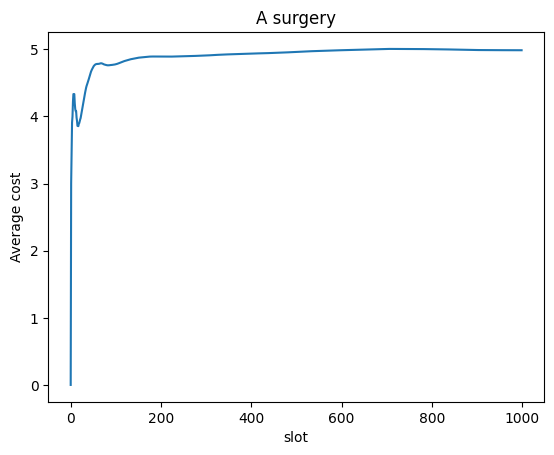

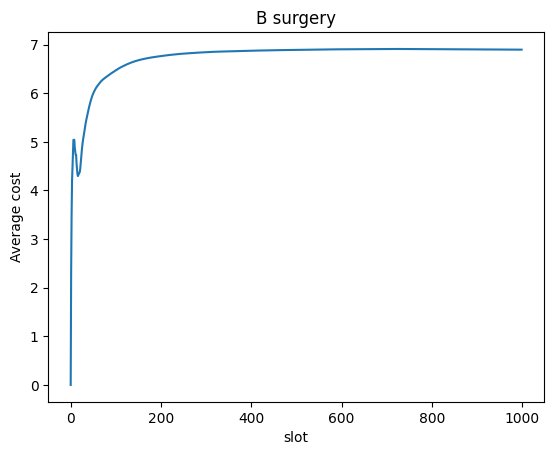

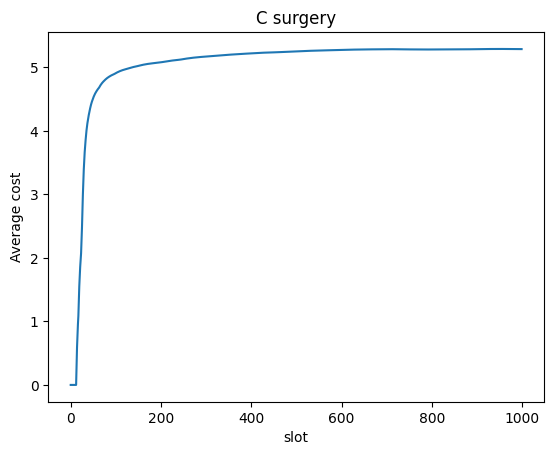

In [16]:
plt.figure()
plt.plot(range(slot), mean3[:,0])
plt.xlabel('slot')
plt.ylabel('Average cost')
plt.title('A surgery')

plt.figure()
plt.plot(range(slot), mean3[:,1])
plt.xlabel('slot')
plt.ylabel('Average cost')
plt.title('B surgery')

plt.figure()
plt.plot(range(slot), mean3[:,2])
plt.xlabel('slot')
plt.ylabel('Average cost')
plt.title('C surgery')

# B:

In [17]:
Men_Free = list(['A', 'B', 'C'])
Women_Free = list(['a', 'b', 'c'])
DA(Men_Free, hospital)

{'A': 'b', 'B': 'a', 'C': 'c'}

In [18]:
def update_queue(queue, K, Matches):
    nonempty_keys = [key for key, value in Matches.items() if value != '']
    for x in nonempty_keys:
        i = queue.find(x[0])
        queue = queue.replace(x[0], '', 1)
        K = K.replace(K[i], '', 1)
    return queue, K

In [19]:
'''
k = '1'
np.random.seed(0)
landa = 1.0
request_A = np.random.poisson(lam = 0.20 * landa, size = slot * slot_duration)
request_B = np.random.poisson(lam = 0.10 * landa, size = slot * slot_duration)
request_C = np.random.poisson(lam = 0.05 * landa, size = slot * slot_duration)

request_slot = []
for i in range(slot):
  x = []
  for j in range(slot_duration):
    x.append('A' * request_A[(i-1)*slot_duration + j])
    x.append('B' * request_B[(i-1)*slot_duration + j])
    x.append('C' * request_C[(i-1)*slot_duration + j])
  x = [i for i in x if i != '']
  x = ''.join(x)
  request_slot.append(x)

Women_Free = list(['a', 'b', 'c'])
busy_slots = np.array([0, 0, 0])
M1 = np.zeros([1+slot, 3]); M2 = np.zeros([1+slot, 3]); n = np.ones([1+slot, 3]);
M3 = np.zeros([1+slot, 3]); mean1 = np.zeros([slot, 3]); mean2 = np.zeros([slot, 3]);
mean3 = np.zeros([slot, 3]);

K = ''
queue = ''
total_req = ''
Matches = [None] * slot
for t in range(slot):
    queue = queue + request_slot[t]
    K = K + len(request_slot[t]) * k
    total_req = total_req + request_slot[t]

    d = len(Women_Free)
    Women_Free_saved = Women_Free[:]
    selected_queue = []
    for i, q in enumerate(queue):
        if K[i] == '0':
            selected_queue.append(q)
            queue = queue[i] + queue[:i] + queue[i+1:]
            K = K[i] + K[:i] + K[i+1:]
            Women_Free = Women_Free [1:]
        elif q == 'A':
            if 'b' in Women_Free:
                Women_Free.remove('b')
                selected_queue.append(q)
                queue = queue[i] + queue[:i] + queue[i+1:]
                K = K[i] + K[:i] + K[i+1:]
            else:
                K = K[:i] + str(eval(K[i]) - 1) + K[i+1:]

        elif q == 'B':
            if 'a' in Women_Free:
                Women_Free.remove('a')
                selected_queue.append(q)
                queue = queue[i] + queue[:i] + queue[i+1:]
                K = K[i] + K[:i] + K[i+1:]
            else:
                K = K[:i] + str(eval(K[i]) - 1) + K[i+1:]

        elif q == 'C':
            if 'c' in Women_Free:
                Women_Free.remove('c')
                selected_queue.append(q)
                queue = queue[i] + queue[:i] + queue[i+1:]
                K = K[i] + K[:i] + K[i+1:]
            else:
                K = K[:i] + str(eval(K[i]) - 1) + K[i+1:]

        if len(selected_queue) == d:
            break

    Women_Free = Women_Free_saved
    if len(queue) >= 3:
        Men_Free = list(queue[:3])
        Men_Free = convert(Men_Free)
        Matches[t] = (DA(Men_Free, Women_Free))
        queue, K = update_queue(queue, K, Matches[t])
        Women_Free, busy_slots = hospital_free(busy_slots, Matches[t])
        M1[t+1], M2[t+1], M3[t+1], n[t+1] = Mean(Matches[t], M1[t], M2[t], M3[t], n[t])
        mean1[t] = sum(M1[:t+1]) / sum(n[:t+1])
        mean2[t] = sum(M2[:t+1]) / sum(n[:t+1])
        mean3[t] = sum(M3[:t+1]) / sum(n[:t+1])
    else:
        mean1[t] = mean1[t-1]
        mean2[t] = mean2[t-1]
        mean3[t] = mean3[t-1]

print(f'The number of remaining requests out of the total of {len(total_req)} \
is {len(queue)}.')
'''

"\nk = '1'\nnp.random.seed(0)\nlanda = 1.0\nrequest_A = np.random.poisson(lam = 0.20 * landa, size = slot * slot_duration)\nrequest_B = np.random.poisson(lam = 0.10 * landa, size = slot * slot_duration)\nrequest_C = np.random.poisson(lam = 0.05 * landa, size = slot * slot_duration)\n\nrequest_slot = []\nfor i in range(slot):\n  x = []\n  for j in range(slot_duration):\n    x.append('A' * request_A[(i-1)*slot_duration + j])\n    x.append('B' * request_B[(i-1)*slot_duration + j])\n    x.append('C' * request_C[(i-1)*slot_duration + j])\n  x = [i for i in x if i != '']\n  x = ''.join(x)\n  request_slot.append(x)\n\nWomen_Free = list(['a', 'b', 'c'])\nbusy_slots = np.array([0, 0, 0])\nM1 = np.zeros([1+slot, 3]); M2 = np.zeros([1+slot, 3]); n = np.ones([1+slot, 3]);\nM3 = np.zeros([1+slot, 3]); mean1 = np.zeros([slot, 3]); mean2 = np.zeros([slot, 3]);\nmean3 = np.zeros([slot, 3]);\n\nK = ''\nqueue = ''\ntotal_req = ''\nMatches = [None] * slot\nfor t in range(slot):\n    queue = queue + reque

In [20]:
k = '1'
landa = 1.0

np.random.seed(0)
request_A = np.random.poisson(lam = 0.20 * landa, size = slot * slot_duration)
request_B = np.random.poisson(lam = 0.10 * landa, size = slot * slot_duration)
request_C = np.random.poisson(lam = 0.05 * landa, size = slot * slot_duration)

request_slot = []
for i in range(slot):
  x = []
  for j in range(slot_duration):
    x.append('A' * request_A[(i-1)*slot_duration + j])
    x.append('B' * request_B[(i-1)*slot_duration + j])
    x.append('C' * request_C[(i-1)*slot_duration + j])
  x = [i for i in x if i != '']
  x = ''.join(x)
  request_slot.append(x)

Women_Free = list(['a', 'b', 'c'])
busy_slots = np.array([0, 0, 0])
M1 = np.zeros([1+slot, 3]); M2 = np.zeros([1+slot, 3]); n = np.ones([1+slot, 3]);
M3 = np.zeros([1+slot, 3]); mean1 = np.zeros([slot, 3]); mean2 = np.zeros([slot, 3]);
mean3 = np.zeros([slot, 3]);

K = ''
queue = ''
total_req = ''
Matches = [None] * slot
for t in range(slot):
    queue = queue + request_slot[t]
    K = K + len(request_slot[t]) * k
    total_req = total_req + request_slot[t]

    for i, q in enumerate(queue):
        if q == 'A':
            if 'b' in Women_Free or K[i] == '0':
                queue = queue[i] + queue[:i] + queue[i+1:]
                K = K[i] + K[:i] + K[i+1:]
            else:
                K = K[:i] + str(eval(K[i]) - 1) + K[i+1:]

        elif q == 'B':
            if 'a' in Women_Free or K[i] == '0':
                queue = queue[i] + queue[:i] + queue[i+1:]
                K = K[i] + K[:i] + K[i+1:]
            else:
                K = K[:i] + str(eval(K[i]) - 1) + K[i+1:]

        elif q == 'C':
            if 'c' in Women_Free or K[i] == '0':
                queue = queue[i] + queue[:i] + queue[i+1:]
                K = K[i] + K[:i] + K[i+1:]
            else:
                K = K[:i] + str(eval(K[i]) - 1) + K[i+1:]

    if len(queue) >= 3:
        Men_Free = list(queue[:3])
        Men_Free = convert(Men_Free)
        Matches[t] = (DA(Men_Free, Women_Free))
        queue, K = update_queue(queue, K, Matches[t])
        Women_Free, busy_slots = hospital_free(busy_slots, Matches[t])
        M1[t+1], M2[t+1], M3[t+1], n[t+1] = Mean(Matches[t], M1[t], M2[t], M3[t], n[t])
        mean1[t] = sum(M1[:t+1]) / sum(n[:t+1])
        mean2[t] = sum(M2[:t+1]) / sum(n[:t+1])
        mean3[t] = sum(M3[:t+1]) / sum(n[:t+1])
    else:
        mean1[t] = mean1[t-1]
        mean2[t] = mean2[t-1]
        mean3[t] = mean3[t-1]

print(f'The number of remaining requests out of the total of {len(total_req)} \
is {len(queue)}.')

The number of remaining requests out of the total of 2774 is 908.


In [21]:
k = '2'
landa = 1.0

np.random.seed(0)
request_A = np.random.poisson(lam = 0.20 * landa, size = slot * slot_duration)
request_B = np.random.poisson(lam = 0.10 * landa, size = slot * slot_duration)
request_C = np.random.poisson(lam = 0.05 * landa, size = slot * slot_duration)

request_slot = []
for i in range(slot):
  x = []
  for j in range(slot_duration):
    x.append('A' * request_A[(i-1)*slot_duration + j])
    x.append('B' * request_B[(i-1)*slot_duration + j])
    x.append('C' * request_C[(i-1)*slot_duration + j])
  x = [i for i in x if i != '']
  x = ''.join(x)
  request_slot.append(x)

Women_Free = list(['a', 'b', 'c'])
busy_slots = np.array([0, 0, 0])
M1 = np.zeros([1+slot, 3]); M2 = np.zeros([1+slot, 3]); n = np.ones([1+slot, 3]);
M3 = np.zeros([1+slot, 3]); mean1 = np.zeros([slot, 3]); mean2 = np.zeros([slot, 3]);
mean3 = np.zeros([slot, 3]);

K = ''
queue = ''
total_req = ''
Matches = [None] * slot
for t in range(slot):
    queue = queue + request_slot[t]
    K = K + len(request_slot[t]) * k
    total_req = total_req + request_slot[t]

    for i, q in enumerate(queue):
        if q == 'A':
            if 'b' in Women_Free or K[i] == '0':
                queue = queue[i] + queue[:i] + queue[i+1:]
                K = K[i] + K[:i] + K[i+1:]
            else:
                K = K[:i] + str(eval(K[i]) - 1) + K[i+1:]

        elif q == 'B':
            if 'a' in Women_Free or K[i] == '0':
                queue = queue[i] + queue[:i] + queue[i+1:]
                K = K[i] + K[:i] + K[i+1:]
            else:
                K = K[:i] + str(eval(K[i]) - 1) + K[i+1:]

        elif q == 'C':
            if 'c' in Women_Free or K[i] == '0':
                queue = queue[i] + queue[:i] + queue[i+1:]
                K = K[i] + K[:i] + K[i+1:]
            else:
                K = K[:i] + str(eval(K[i]) - 1) + K[i+1:]

    if len(queue) >= 3:
        Men_Free = list(queue[:3])
        Men_Free = convert(Men_Free)
        Matches[t] = (DA(Men_Free, Women_Free))
        queue, K = update_queue(queue, K, Matches[t])
        Women_Free, busy_slots = hospital_free(busy_slots, Matches[t])
        M1[t+1], M2[t+1], M3[t+1], n[t+1] = Mean(Matches[t], M1[t], M2[t], M3[t], n[t])
        mean1[t] = sum(M1[:t+1]) / sum(n[:t+1])
        mean2[t] = sum(M2[:t+1]) / sum(n[:t+1])
        mean3[t] = sum(M3[:t+1]) / sum(n[:t+1])
    else:
        mean1[t] = mean1[t-1]
        mean2[t] = mean2[t-1]
        mean3[t] = mean3[t-1]

print(f'The number of remaining requests out of the total of {len(total_req)} \
is {len(queue)}.')

The number of remaining requests out of the total of 2774 is 891.


In [22]:
k = '3'
landa = 1.0

np.random.seed(0)
request_A = np.random.poisson(lam = 0.20 * landa, size = slot * slot_duration)
request_B = np.random.poisson(lam = 0.10 * landa, size = slot * slot_duration)
request_C = np.random.poisson(lam = 0.05 * landa, size = slot * slot_duration)

request_slot = []
for i in range(slot):
  x = []
  for j in range(slot_duration):
    x.append('A' * request_A[(i-1)*slot_duration + j])
    x.append('B' * request_B[(i-1)*slot_duration + j])
    x.append('C' * request_C[(i-1)*slot_duration + j])
  x = [i for i in x if i != '']
  x = ''.join(x)
  request_slot.append(x)

Women_Free = list(['a', 'b', 'c'])
busy_slots = np.array([0, 0, 0])
M1 = np.zeros([1+slot, 3]); M2 = np.zeros([1+slot, 3]); n = np.ones([1+slot, 3]);
M3 = np.zeros([1+slot, 3]); mean1 = np.zeros([slot, 3]); mean2 = np.zeros([slot, 3]);
mean3 = np.zeros([slot, 3]);

K = ''
queue = ''
total_req = ''
Matches = [None] * slot
for t in range(slot):
    queue = queue + request_slot[t]
    K = K + len(request_slot[t]) * k
    total_req = total_req + request_slot[t]

    for i, q in enumerate(queue):
        if q == 'A':
            if 'b' in Women_Free or K[i] == '0':
                queue = queue[i] + queue[:i] + queue[i+1:]
                K = K[i] + K[:i] + K[i+1:]
            else:
                K = K[:i] + str(eval(K[i]) - 1) + K[i+1:]

        elif q == 'B':
            if 'a' in Women_Free or K[i] == '0':
                queue = queue[i] + queue[:i] + queue[i+1:]
                K = K[i] + K[:i] + K[i+1:]
            else:
                K = K[:i] + str(eval(K[i]) - 1) + K[i+1:]

        elif q == 'C':
            if 'c' in Women_Free or K[i] == '0':
                queue = queue[i] + queue[:i] + queue[i+1:]
                K = K[i] + K[:i] + K[i+1:]
            else:
                K = K[:i] + str(eval(K[i]) - 1) + K[i+1:]

    if len(queue) >= 3:
        Men_Free = list(queue[:3])
        Men_Free = convert(Men_Free)
        Matches[t] = (DA(Men_Free, Women_Free))
        queue, K = update_queue(queue, K, Matches[t])
        Women_Free, busy_slots = hospital_free(busy_slots, Matches[t])
        M1[t+1], M2[t+1], M3[t+1], n[t+1] = Mean(Matches[t], M1[t], M2[t], M3[t], n[t])
        mean1[t] = sum(M1[:t+1]) / sum(n[:t+1])
        mean2[t] = sum(M2[:t+1]) / sum(n[:t+1])
        mean3[t] = sum(M3[:t+1]) / sum(n[:t+1])
    else:
        mean1[t] = mean1[t-1]
        mean2[t] = mean2[t-1]
        mean3[t] = mean3[t-1]

print(f'The number of remaining requests out of the total of {len(total_req)} \
is {len(queue)}.')

The number of remaining requests out of the total of 2774 is 896.


In [23]:
k = '4'
landa = 1.0

np.random.seed(0)
request_A = np.random.poisson(lam = 0.20 * landa, size = slot * slot_duration)
request_B = np.random.poisson(lam = 0.10 * landa, size = slot * slot_duration)
request_C = np.random.poisson(lam = 0.05 * landa, size = slot * slot_duration)

request_slot = []
for i in range(slot):
  x = []
  for j in range(slot_duration):
    x.append('A' * request_A[(i-1)*slot_duration + j])
    x.append('B' * request_B[(i-1)*slot_duration + j])
    x.append('C' * request_C[(i-1)*slot_duration + j])
  x = [i for i in x if i != '']
  x = ''.join(x)
  request_slot.append(x)

Women_Free = list(['a', 'b', 'c'])
busy_slots = np.array([0, 0, 0])
M1 = np.zeros([1+slot, 3]); M2 = np.zeros([1+slot, 3]); n = np.ones([1+slot, 3]);
M3 = np.zeros([1+slot, 3]); mean1 = np.zeros([slot, 3]); mean2 = np.zeros([slot, 3]);
mean3 = np.zeros([slot, 3]);

K = ''
queue = ''
total_req = ''
Matches = [None] * slot
for t in range(slot):
    queue = queue + request_slot[t]
    K = K + len(request_slot[t]) * k
    total_req = total_req + request_slot[t]

    for i, q in enumerate(queue):
        if q == 'A':
            if 'b' in Women_Free or K[i] == '0':
                queue = queue[i] + queue[:i] + queue[i+1:]
                K = K[i] + K[:i] + K[i+1:]
            else:
                K = K[:i] + str(eval(K[i]) - 1) + K[i+1:]

        elif q == 'B':
            if 'a' in Women_Free or K[i] == '0':
                queue = queue[i] + queue[:i] + queue[i+1:]
                K = K[i] + K[:i] + K[i+1:]
            else:
                K = K[:i] + str(eval(K[i]) - 1) + K[i+1:]

        elif q == 'C':
            if 'c' in Women_Free or K[i] == '0':
                queue = queue[i] + queue[:i] + queue[i+1:]
                K = K[i] + K[:i] + K[i+1:]
            else:
                K = K[:i] + str(eval(K[i]) - 1) + K[i+1:]

    if len(queue) >= 3:
        Men_Free = list(queue[:3])
        Men_Free = convert(Men_Free)
        Matches[t] = (DA(Men_Free, Women_Free))
        queue, K = update_queue(queue, K, Matches[t])
        Women_Free, busy_slots = hospital_free(busy_slots, Matches[t])
        M1[t+1], M2[t+1], M3[t+1], n[t+1] = Mean(Matches[t], M1[t], M2[t], M3[t], n[t])
        mean1[t] = sum(M1[:t+1]) / sum(n[:t+1])
        mean2[t] = sum(M2[:t+1]) / sum(n[:t+1])
        mean3[t] = sum(M3[:t+1]) / sum(n[:t+1])
    else:
        mean1[t] = mean1[t-1]
        mean2[t] = mean2[t-1]
        mean3[t] = mean3[t-1]

print(f'The number of remaining requests out of the total of {len(total_req)} \
is {len(queue)}.')

The number of remaining requests out of the total of 2774 is 883.


In [24]:
k = '5'
landa = 1.0

np.random.seed(0)
request_A = np.random.poisson(lam = 0.20 * landa, size = slot * slot_duration)
request_B = np.random.poisson(lam = 0.10 * landa, size = slot * slot_duration)
request_C = np.random.poisson(lam = 0.05 * landa, size = slot * slot_duration)

request_slot = []
for i in range(slot):
  x = []
  for j in range(slot_duration):
    x.append('A' * request_A[(i-1)*slot_duration + j])
    x.append('B' * request_B[(i-1)*slot_duration + j])
    x.append('C' * request_C[(i-1)*slot_duration + j])
  x = [i for i in x if i != '']
  x = ''.join(x)
  request_slot.append(x)

Women_Free = list(['a', 'b', 'c'])
busy_slots = np.array([0, 0, 0])
M1 = np.zeros([1+slot, 3]); M2 = np.zeros([1+slot, 3]); n = np.ones([1+slot, 3]);
M3 = np.zeros([1+slot, 3]); mean1 = np.zeros([slot, 3]); mean2 = np.zeros([slot, 3]);
mean3 = np.zeros([slot, 3]);

K = ''
queue = ''
total_req = ''
Matches = [None] * slot
for t in range(slot):
    queue = queue + request_slot[t]
    K = K + len(request_slot[t]) * k
    total_req = total_req + request_slot[t]

    for i, q in enumerate(queue):
        if q == 'A':
            if 'b' in Women_Free or K[i] == '0':
                queue = queue[i] + queue[:i] + queue[i+1:]
                K = K[i] + K[:i] + K[i+1:]
            else:
                K = K[:i] + str(eval(K[i]) - 1) + K[i+1:]
                M2[t][0] += slot_duration

        elif q == 'B':
            if 'a' in Women_Free or K[i] == '0':
                queue = queue[i] + queue[:i] + queue[i+1:]
                K = K[i] + K[:i] + K[i+1:]
            else:
                K = K[:i] + str(eval(K[i]) - 1) + K[i+1:]
                M2[t][1] += slot_duration

        elif q == 'C':
            if 'c' in Women_Free or K[i] == '0':
                queue = queue[i] + queue[:i] + queue[i+1:]
                K = K[i] + K[:i] + K[i+1:]
            else:
                K = K[:i] + str(eval(K[i]) - 1) + K[i+1:]
                M2[t][2] += slot_duration

    if len(queue) >= 3:
        Men_Free = list(queue[:3])
        Men_Free = convert(Men_Free)
        Matches[t] = (DA(Men_Free, Women_Free))
        queue, K = update_queue(queue, K, Matches[t])
        Women_Free, busy_slots = hospital_free(busy_slots, Matches[t])
        M1[t+1], M2[t+1], M3[t+1], n[t+1] = Mean(Matches[t], M1[t], M2[t], M3[t], n[t])
        mean1[t] = sum(M1[:t+1]) / sum(n[:t+1])
        mean2[t] = sum(M2[:t+1]) / sum(n[:t+1])
        mean3[t] = sum(M3[:t+1]) / sum(n[:t+1])
    else:
        mean1[t] = mean1[t-1]
        mean2[t] = mean2[t-1]
        mean3[t] = mean3[t-1]

print(f'The number of remaining requests out of the total of {len(total_req)} \
is {len(queue)}.')

The number of remaining requests out of the total of 2774 is 886.


Text(0.5, 1.0, 'C surgery')

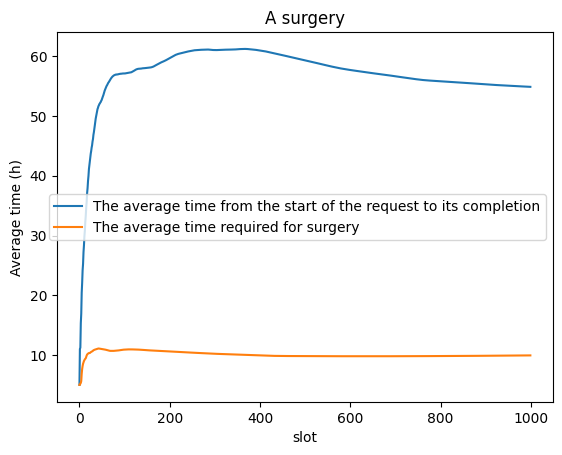

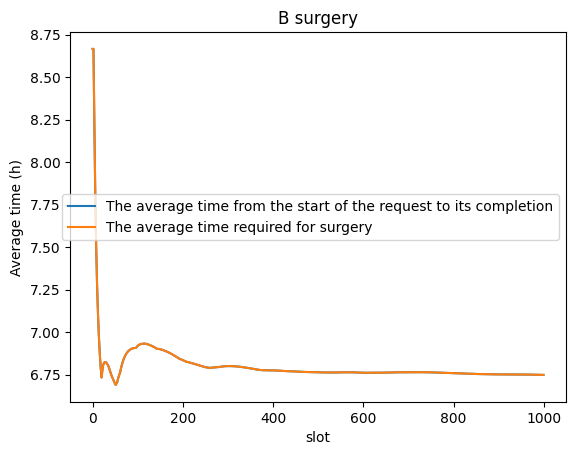

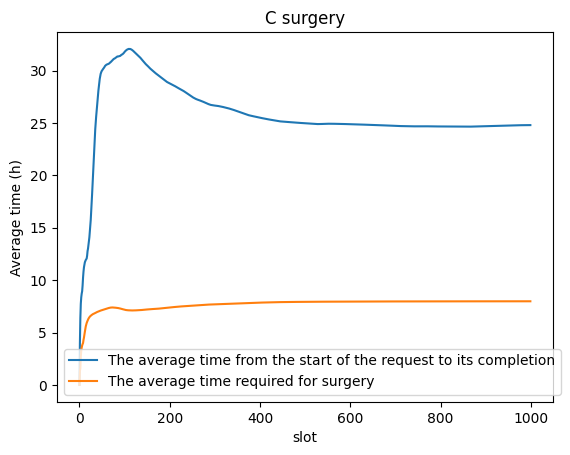

In [25]:
plt.figure()
plt.plot(range(slot), mean2[:,0])
plt.plot(range(slot), mean1[:,0])
plt.xlabel('slot')
plt.ylabel('Average time (h)')
plt.legend(['The average time from the start of the request to its completion', \
            'The average time required for surgery'])
plt.title('A surgery')

plt.figure()
plt.plot(range(slot), mean2[:,1])
plt.plot(range(slot), mean1[:,1])
plt.xlabel('slot')
plt.ylabel('Average time (h)')
plt.legend(['The average time from the start of the request to its completion', \
            'The average time required for surgery'])
plt.title('B surgery')

plt.figure()
plt.plot(range(slot), mean2[:,2])
plt.plot(range(slot), mean1[:,2])
plt.xlabel('slot')
plt.ylabel('Average time (h)')
plt.legend(['The average time from the start of the request to its completion', \
            'The average time required for surgery'])
plt.title('C surgery')

Text(0.5, 1.0, 'C surgery')

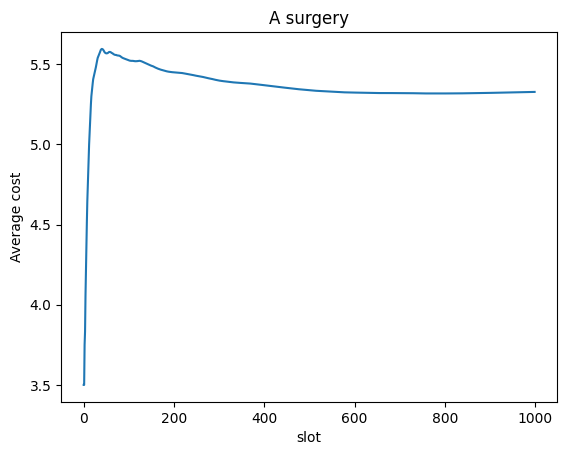

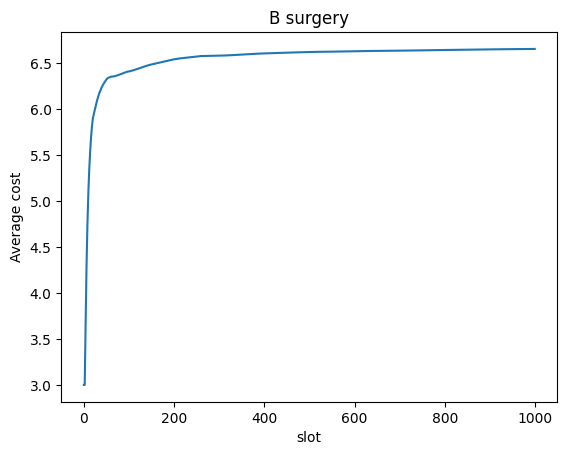

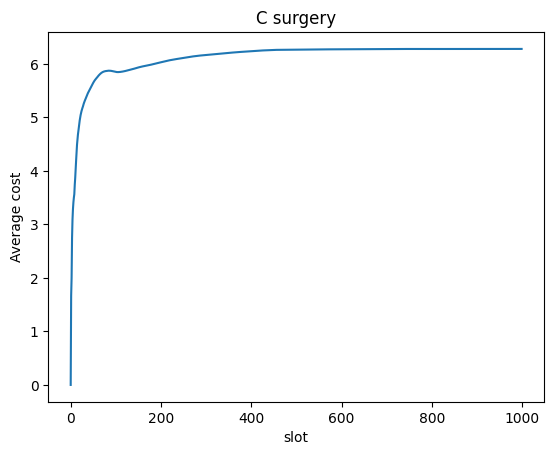

In [26]:
plt.figure()
plt.plot(range(slot), mean3[:,0])
plt.xlabel('slot')
plt.ylabel('Average cost')
plt.title('A surgery')

plt.figure()
plt.plot(range(slot), mean3[:,1])
plt.xlabel('slot')
plt.ylabel('Average cost')
plt.title('B surgery')

plt.figure()
plt.plot(range(slot), mean3[:,2])
plt.xlabel('slot')
plt.ylabel('Average cost')
plt.title('C surgery')

In [30]:
k = '1'
landa = 0.9 ** 4.05

np.random.seed(0)
request_A = np.random.poisson(lam = 0.20 * landa, size = slot * slot_duration)
request_B = np.random.poisson(lam = 0.10 * landa, size = slot * slot_duration)
request_C = np.random.poisson(lam = 0.05 * landa, size = slot * slot_duration)

request_slot = []
for i in range(slot):
  x = []
  for j in range(slot_duration):
    x.append('A' * request_A[(i-1)*slot_duration + j])
    x.append('B' * request_B[(i-1)*slot_duration + j])
    x.append('C' * request_C[(i-1)*slot_duration + j])
  x = [i for i in x if i != '']
  x = ''.join(x)
  request_slot.append(x)

Women_Free = list(['a', 'b', 'c'])
busy_slots = np.array([0, 0, 0])
M1 = np.zeros([1+slot, 3]); M2 = np.zeros([1+slot, 3]); n = np.ones([1+slot, 3]);
M3 = np.zeros([1+slot, 3]); mean1 = np.zeros([slot, 3]); mean2 = np.zeros([slot, 3]);
mean3 = np.zeros([slot, 3]);

K = ''
queue = ''
total_req = ''
Matches = [None] * slot
for t in range(slot):
    queue = queue + request_slot[t]
    K = K + len(request_slot[t]) * k
    total_req = total_req + request_slot[t]

    for i, q in enumerate(queue):
        if q == 'A':
            if 'b' in Women_Free or K[i] == '0':
                queue = queue[i] + queue[:i] + queue[i+1:]
                K = K[i] + K[:i] + K[i+1:]
            else:
                K = K[:i] + str(eval(K[i]) - 1) + K[i+1:]
                M2[t][0] += slot_duration

        elif q == 'B':
            if 'a' in Women_Free or K[i] == '0':
                queue = queue[i] + queue[:i] + queue[i+1:]
                K = K[i] + K[:i] + K[i+1:]
            else:
                K = K[:i] + str(eval(K[i]) - 1) + K[i+1:]
                M2[t][1] += slot_duration

        elif q == 'C':
            if 'c' in Women_Free or K[i] == '0':
                queue = queue[i] + queue[:i] + queue[i+1:]
                K = K[i] + K[:i] + K[i+1:]
            else:
                K = K[:i] + str(eval(K[i]) - 1) + K[i+1:]
                M2[t][2] += slot_duration

    if len(queue) >= 3:
        Men_Free = list(queue[:3])
        Men_Free = convert(Men_Free)
        Matches[t] = (DA(Men_Free, Women_Free))
        queue, K = update_queue(queue, K, Matches[t])
        Women_Free, busy_slots = hospital_free(busy_slots, Matches[t])
        M1[t+1], M2[t+1], M3[t+1], n[t+1] = Mean(Matches[t], M1[t], M2[t], M3[t], n[t])
        mean1[t] = sum(M1[:t+1]) / sum(n[:t+1])
        mean2[t] = sum(M2[:t+1]) / sum(n[:t+1])
        mean3[t] = sum(M3[:t+1]) / sum(n[:t+1])
    else:
        mean1[t] = mean1[t-1]
        mean2[t] = mean2[t-1]
        mean3[t] = mean3[t-1]

print(f'The number of remaining requests out of the total of {len(total_req)} \
is {len(queue)}.')

The number of remaining requests out of the total of 1811 is 8.


In [32]:
k = '2'
landa = 0.9 ** 4

np.random.seed(0)
request_A = np.random.poisson(lam = 0.20 * landa, size = slot * slot_duration)
request_B = np.random.poisson(lam = 0.10 * landa, size = slot * slot_duration)
request_C = np.random.poisson(lam = 0.05 * landa, size = slot * slot_duration)

request_slot = []
for i in range(slot):
  x = []
  for j in range(slot_duration):
    x.append('A' * request_A[(i-1)*slot_duration + j])
    x.append('B' * request_B[(i-1)*slot_duration + j])
    x.append('C' * request_C[(i-1)*slot_duration + j])
  x = [i for i in x if i != '']
  x = ''.join(x)
  request_slot.append(x)

Women_Free = list(['a', 'b', 'c'])
busy_slots = np.array([0, 0, 0])
M1 = np.zeros([1+slot, 3]); M2 = np.zeros([1+slot, 3]); n = np.ones([1+slot, 3]);
M3 = np.zeros([1+slot, 3]); mean1 = np.zeros([slot, 3]); mean2 = np.zeros([slot, 3]);
mean3 = np.zeros([slot, 3]);

K = ''
queue = ''
total_req = ''
Matches = [None] * slot
for t in range(slot):
    queue = queue + request_slot[t]
    K = K + len(request_slot[t]) * k
    total_req = total_req + request_slot[t]

    for i, q in enumerate(queue):
        if q == 'A':
            if 'b' in Women_Free or K[i] == '0':
                queue = queue[i] + queue[:i] + queue[i+1:]
                K = K[i] + K[:i] + K[i+1:]
            else:
                K = K[:i] + str(eval(K[i]) - 1) + K[i+1:]
                M2[t][0] += slot_duration

        elif q == 'B':
            if 'a' in Women_Free or K[i] == '0':
                queue = queue[i] + queue[:i] + queue[i+1:]
                K = K[i] + K[:i] + K[i+1:]
            else:
                K = K[:i] + str(eval(K[i]) - 1) + K[i+1:]
                M2[t][1] += slot_duration

        elif q == 'C':
            if 'c' in Women_Free or K[i] == '0':
                queue = queue[i] + queue[:i] + queue[i+1:]
                K = K[i] + K[:i] + K[i+1:]
            else:
                K = K[:i] + str(eval(K[i]) - 1) + K[i+1:]
                M2[t][2] += slot_duration

    if len(queue) >= 3:
        Men_Free = list(queue[:3])
        Men_Free = convert(Men_Free)
        Matches[t] = (DA(Men_Free, Women_Free))
        queue, K = update_queue(queue, K, Matches[t])
        Women_Free, busy_slots = hospital_free(busy_slots, Matches[t])
        M1[t+1], M2[t+1], M3[t+1], n[t+1] = Mean(Matches[t], M1[t], M2[t], M3[t], n[t])
        mean1[t] = sum(M1[:t+1]) / sum(n[:t+1])
        mean2[t] = sum(M2[:t+1]) / sum(n[:t+1])
        mean3[t] = sum(M3[:t+1]) / sum(n[:t+1])
    else:
        mean1[t] = mean1[t-1]
        mean2[t] = mean2[t-1]
        mean3[t] = mean3[t-1]

print(f'The number of remaining requests out of the total of {len(total_req)} \
is {len(queue)}.')

The number of remaining requests out of the total of 1818 is 7.


In [36]:
k = '3'
landa = 0.9 ** 4

np.random.seed(0)
request_A = np.random.poisson(lam = 0.20 * landa, size = slot * slot_duration)
request_B = np.random.poisson(lam = 0.10 * landa, size = slot * slot_duration)
request_C = np.random.poisson(lam = 0.05 * landa, size = slot * slot_duration)

request_slot = []
for i in range(slot):
  x = []
  for j in range(slot_duration):
    x.append('A' * request_A[(i-1)*slot_duration + j])
    x.append('B' * request_B[(i-1)*slot_duration + j])
    x.append('C' * request_C[(i-1)*slot_duration + j])
  x = [i for i in x if i != '']
  x = ''.join(x)
  request_slot.append(x)

Women_Free = list(['a', 'b', 'c'])
busy_slots = np.array([0, 0, 0])
M1 = np.zeros([1+slot, 3]); M2 = np.zeros([1+slot, 3]); n = np.ones([1+slot, 3]);
M3 = np.zeros([1+slot, 3]); mean1 = np.zeros([slot, 3]); mean2 = np.zeros([slot, 3]);
mean3 = np.zeros([slot, 3]);

K = ''
queue = ''
total_req = ''
Matches = [None] * slot
for t in range(slot):
    queue = queue + request_slot[t]
    K = K + len(request_slot[t]) * k
    total_req = total_req + request_slot[t]

    for i, q in enumerate(queue):
        if q == 'A':
            if 'b' in Women_Free or K[i] == '0':
                queue = queue[i] + queue[:i] + queue[i+1:]
                K = K[i] + K[:i] + K[i+1:]
            else:
                K = K[:i] + str(eval(K[i]) - 1) + K[i+1:]
                M2[t][0] += slot_duration

        elif q == 'B':
            if 'a' in Women_Free or K[i] == '0':
                queue = queue[i] + queue[:i] + queue[i+1:]
                K = K[i] + K[:i] + K[i+1:]
            else:
                K = K[:i] + str(eval(K[i]) - 1) + K[i+1:]
                M2[t][1] += slot_duration

        elif q == 'C':
            if 'c' in Women_Free or K[i] == '0':
                queue = queue[i] + queue[:i] + queue[i+1:]
                K = K[i] + K[:i] + K[i+1:]
            else:
                K = K[:i] + str(eval(K[i]) - 1) + K[i+1:]
                M2[t][2] += slot_duration

    if len(queue) >= 3:
        Men_Free = list(queue[:3])
        Men_Free = convert(Men_Free)
        Matches[t] = (DA(Men_Free, Women_Free))
        queue, K = update_queue(queue, K, Matches[t])
        Women_Free, busy_slots = hospital_free(busy_slots, Matches[t])
        M1[t+1], M2[t+1], M3[t+1], n[t+1] = Mean(Matches[t], M1[t], M2[t], M3[t], n[t])
        mean1[t] = sum(M1[:t+1]) / sum(n[:t+1])
        mean2[t] = sum(M2[:t+1]) / sum(n[:t+1])
        mean3[t] = sum(M3[:t+1]) / sum(n[:t+1])
    else:
        mean1[t] = mean1[t-1]
        mean2[t] = mean2[t-1]
        mean3[t] = mean3[t-1]

print(f'The number of remaining requests out of the total of {len(total_req)} \
is {len(queue)}.')

The number of remaining requests out of the total of 1818 is 6.


In [41]:
k = '4'
landa = 0.9 ** 3.95

np.random.seed(0)
request_A = np.random.poisson(lam = 0.20 * landa, size = slot * slot_duration)
request_B = np.random.poisson(lam = 0.10 * landa, size = slot * slot_duration)
request_C = np.random.poisson(lam = 0.05 * landa, size = slot * slot_duration)

request_slot = []
for i in range(slot):
  x = []
  for j in range(slot_duration):
    x.append('A' * request_A[(i-1)*slot_duration + j])
    x.append('B' * request_B[(i-1)*slot_duration + j])
    x.append('C' * request_C[(i-1)*slot_duration + j])
  x = [i for i in x if i != '']
  x = ''.join(x)
  request_slot.append(x)

Women_Free = list(['a', 'b', 'c'])
busy_slots = np.array([0, 0, 0])
M1 = np.zeros([1+slot, 3]); M2 = np.zeros([1+slot, 3]); n = np.ones([1+slot, 3]);
M3 = np.zeros([1+slot, 3]); mean1 = np.zeros([slot, 3]); mean2 = np.zeros([slot, 3]);
mean3 = np.zeros([slot, 3]);

K = ''
queue = ''
total_req = ''
Matches = [None] * slot
for t in range(slot):
    queue = queue + request_slot[t]
    K = K + len(request_slot[t]) * k
    total_req = total_req + request_slot[t]

    for i, q in enumerate(queue):
        if q == 'A':
            if 'b' in Women_Free or K[i] == '0':
                queue = queue[i] + queue[:i] + queue[i+1:]
                K = K[i] + K[:i] + K[i+1:]
            else:
                K = K[:i] + str(eval(K[i]) - 1) + K[i+1:]
                M2[t][0] += slot_duration

        elif q == 'B':
            if 'a' in Women_Free or K[i] == '0':
                queue = queue[i] + queue[:i] + queue[i+1:]
                K = K[i] + K[:i] + K[i+1:]
            else:
                K = K[:i] + str(eval(K[i]) - 1) + K[i+1:]
                M2[t][1] += slot_duration

        elif q == 'C':
            if 'c' in Women_Free or K[i] == '0':
                queue = queue[i] + queue[:i] + queue[i+1:]
                K = K[i] + K[:i] + K[i+1:]
            else:
                K = K[:i] + str(eval(K[i]) - 1) + K[i+1:]
                M2[t][2] += slot_duration

    if len(queue) >= 3:
        Men_Free = list(queue[:3])
        Men_Free = convert(Men_Free)
        Matches[t] = (DA(Men_Free, Women_Free))
        queue, K = update_queue(queue, K, Matches[t])
        Women_Free, busy_slots = hospital_free(busy_slots, Matches[t])
        M1[t+1], M2[t+1], M3[t+1], n[t+1] = Mean(Matches[t], M1[t], M2[t], M3[t], n[t])
        mean1[t] = sum(M1[:t+1]) / sum(n[:t+1])
        mean2[t] = sum(M2[:t+1]) / sum(n[:t+1])
        mean3[t] = sum(M3[:t+1]) / sum(n[:t+1])
    else:
        mean1[t] = mean1[t-1]
        mean2[t] = mean2[t-1]
        mean3[t] = mean3[t-1]

print(f'The number of remaining requests out of the total of {len(total_req)} \
is {len(queue)}.')

The number of remaining requests out of the total of 1827 is 8.


In [43]:
k = '5'
landa = 0.9 ** 3.92

np.random.seed(0)
request_A = np.random.poisson(lam = 0.20 * landa, size = slot * slot_duration)
request_B = np.random.poisson(lam = 0.10 * landa, size = slot * slot_duration)
request_C = np.random.poisson(lam = 0.05 * landa, size = slot * slot_duration)

request_slot = []
for i in range(slot):
  x = []
  for j in range(slot_duration):
    x.append('A' * request_A[(i-1)*slot_duration + j])
    x.append('B' * request_B[(i-1)*slot_duration + j])
    x.append('C' * request_C[(i-1)*slot_duration + j])
  x = [i for i in x if i != '']
  x = ''.join(x)
  request_slot.append(x)

Women_Free = list(['a', 'b', 'c'])
busy_slots = np.array([0, 0, 0])
M1 = np.zeros([1+slot, 3]); M2 = np.zeros([1+slot, 3]); n = np.ones([1+slot, 3]);
M3 = np.zeros([1+slot, 3]); mean1 = np.zeros([slot, 3]); mean2 = np.zeros([slot, 3]);
mean3 = np.zeros([slot, 3]);

K = ''
queue = ''
total_req = ''
Matches = [None] * slot
for t in range(slot):
    queue = queue + request_slot[t]
    K = K + len(request_slot[t]) * k
    total_req = total_req + request_slot[t]

    for i, q in enumerate(queue):
        if q == 'A':
            if 'b' in Women_Free or K[i] == '0':
                queue = queue[i] + queue[:i] + queue[i+1:]
                K = K[i] + K[:i] + K[i+1:]
            else:
                K = K[:i] + str(eval(K[i]) - 1) + K[i+1:]
                M2[t][0] += slot_duration

        elif q == 'B':
            if 'a' in Women_Free or K[i] == '0':
                queue = queue[i] + queue[:i] + queue[i+1:]
                K = K[i] + K[:i] + K[i+1:]
            else:
                K = K[:i] + str(eval(K[i]) - 1) + K[i+1:]
                M2[t][1] += slot_duration

        elif q == 'C':
            if 'c' in Women_Free or K[i] == '0':
                queue = queue[i] + queue[:i] + queue[i+1:]
                K = K[i] + K[:i] + K[i+1:]
            else:
                K = K[:i] + str(eval(K[i]) - 1) + K[i+1:]
                M2[t][2] += slot_duration

    if len(queue) >= 3:
        Men_Free = list(queue[:3])
        Men_Free = convert(Men_Free)
        Matches[t] = (DA(Men_Free, Women_Free))
        queue, K = update_queue(queue, K, Matches[t])
        Women_Free, busy_slots = hospital_free(busy_slots, Matches[t])
        M1[t+1], M2[t+1], M3[t+1], n[t+1] = Mean(Matches[t], M1[t], M2[t], M3[t], n[t])
        mean1[t] = sum(M1[:t+1]) / sum(n[:t+1])
        mean2[t] = sum(M2[:t+1]) / sum(n[:t+1])
        mean3[t] = sum(M3[:t+1]) / sum(n[:t+1])
    else:
        mean1[t] = mean1[t-1]
        mean2[t] = mean2[t-1]
        mean3[t] = mean3[t-1]

print(f'The number of remaining requests out of the total of {len(total_req)} \
is {len(queue)}.')

The number of remaining requests out of the total of 1835 is 9.
